In [154]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import sympy as sp
from IPython.display import clear_output
from sympy import Symbol, symbols, Heaviside
from sympy import Heaviside, simplify, limit
from sympy import re,im, Abs, S, oo
from sympy.solvers import solve, nsolve, solveset
from sympy.matrices import *
from sympy.parsing.sympy_parser import parse_expr
from sympy.utilities.lambdify import lambdify
from sympy.solvers.inequalities import solve_univariate_inequality
from sympy import Interval

from scipy.optimize import fsolve
import math
import time
import warnings
import wolframalpha
warnings.filterwarnings('ignore')

p = sp.symbols('p')
t = sp.symbols('t', positive = True)

#wolframalpha API
client = wolframalpha.Client("23Y65J-LY8H549K5Y")
def wolframQuery(Q):
    res = client.query(Q)
    return next(res.results).text

def prepareQuery(query):
    query = query.replace('Kp', 'a')
    query = query.replace('Ki', 'b')
    query = query.replace('Kv', 'c')
    query = query.replace('p', 's')
    query = query.replace('**', '^')
    return query

def parseAnswer(answer):
    answer = answer.replace('e^', 'exp')
    answer = answer.replace(' + ', '+')
    answer = answer.replace(' - ', '-')
    answer = answer.replace('×','*')
    answer = answer.replace(' ', '*')
    answer = answer.replace('^', '**')
    answer = answer.replace('i', 'I')
    answer = answer.replace('a', 'Kp')
    answer = answer.replace('b', 'Ki')
    answer = answer.replace('c', 'Kv')
    return answer
def makeSymbReal(expr, var):
    for s in expr.atoms(Symbol):
        if(str(s) != var):
            expr = expr.subs([(s, sp.Symbol(str(s), real=True, positive = True))])
    return expr


#Подстановка параметров
def SubExpr(expr, params, excpt = ''):
    for s in  expr.atoms(Symbol):
        if(str(s) != 't' and str(s) != 'w' and str(s) != 'p' and str(s) != excpt):
            expr = expr.subs([(s, params[str(s)] )])
    return expr


#Нахождение оригинала
def FindInverseLaplace(transfer_func):
    return sp.inverse_laplace_transform(transfer_func, p, t)

#Нахождение импульсной переходной и переходной функций
def FindResponses(transfer_func_text):
    transfer_func = parse_expr(transfer_func_text)
    
    for s in transfer_func.atoms(Symbol):
        if(str(s) != 'p'):
            transfer_func = transfer_func.subs([(s, sp.Symbol(str(s), real=True))])

    impulse_response = FindInverseLaplace(transfer_func)
    step_response = FindInverseLaplace(transfer_func/p)
    
    return impulse_response, step_response

#Нахождение импульсной переходной и переходной функций с помощью WolframAlpha
def FindResponsesWolf(transfer_func_text, params, excpt = ''):
        transfer_func = parse_expr(transfer_func_text)
        transfer_func = SubExpr(transfer_func, params,  excpt)
        Q = prepareQuery(str(transfer_func))
        impulse_response_string = wolframQuery('inverselaplace ' + Q)
        step_response_string = wolframQuery('inverselaplace ' + '1/s*'+ Q)
        
        impulse_response_string = parseAnswer(impulse_response_string)
        step_response_string = parseAnswer(step_response_string)
        impulse_response = parse_expr(impulse_response_string)
        impulse_response  = makeSymbReal(impulse_response, '')
        
        step_response = parse_expr(step_response_string)
        step_response  = makeSymbReal(step_response, '')
        return impulse_response, step_response
    
#Уникальные корни в окрестности 0
def FirstUniqueRoots(function):
    rfunction = re(function)
    try: 
        domain = Interval(0.01,S.Infinity)
        solve_univariate_inequality(rfunction> 0,t,False,domain)    
        return np.empty([0])
    except NotImplementedError:
        f = lambdify(t, rfunction)
        solutions = np.empty([0])
        for it in np.arange(0, 0.5, 0.05):
            tmp = fsolve(f, it)[0]
            if (round(round(tmp, 4), 3) == round(round(it, 4), 3) ):
                continue
            solutions = np.append(solutions, tmp)
        solutions = solutions.round(decimals=6)
        solutions = solutions[solutions > 0]
        return np.unique(np.sort(solutions))
        

#Время достижения максимума
def PeakTime(impulse_response, step_response, settling_time):
    roots = FirstUniqueRoots(impulse_response)
    if(roots.size == 0 or roots[0] > 5*settling_time):
        tcur = 0.04
        tmp = re(step_response.subs([(t,tcur)]).evalf())
        while abs(1-tmp) > 0.1:
            tcur += 0.02
            tmp = re(step_response.subs([(t,tcur)]).evalf())
        return tcur, False
    else:
        return roots[0], True

#Перерегулирование
def Overshoot(step_response, tp, tp_exist):
    if tp_exist:
        maximum = re(step_response.subs([(t,tp)]).evalf())
        os = maximum - 1     
    else:
        os = 0
    return  os*100

#Время установления
def SettlingTime(impulse_response, step_response, params, stat_err):
    s = FirstUniqueRoots(impulse_response)
    if(stat_err == 0):
        if s.size == 0:
            tcur = 0.25
            tmp = re(step_response.subs([(t,tcur)]).evalf())

            if abs(1-tmp) > 0.01:
                while abs(1-tmp) > 0.01:
                    tcur += 0.05
                    tmp = re(step_response.subs([(t,tcur)]).evalf())
            else:
                while abs(1-tmp) <= 0.01:
                    tcur -= 0.05
                    tmp = re(step_response.subs([(t,tcur)]).evalf()) 
        elif s.size > 0:
            tcur = s[-1]
            tmp = re(step_response.subs([(t,tcur)]).evalf())
            if(abs(1-tmp) <= 0.01):
                while abs(1-tmp) <= 0.01:
                    tcur -= 0.05
                    tmp = re(step_response.subs([(t,tcur)]).evalf())
            if(abs(1-tmp) > 0.01):
                while abs(1-tmp) > 0.01:
                    tcur += 0.05
                    tmp = re(step_response.subs([(t,tcur)]).evalf())
    else:
        tcur = -1

    return tcur

#Статическая ошибка 
def StaticError(step_response):
    reSR = re(step_response)
    se = limit(reSR, t, oo) - 1
    return se if abs(se) > 1e-15 else 0

#Найти характеристики переходного процесса
def FindResponseChar(impulse_response,step_response, params):
    se = StaticError(step_response) 
    st = SettlingTime(impulse_response, step_response, params,se)
    tp, tp_ex = PeakTime(impulse_response,step_response, st)
    os = Overshoot(step_response, tp, tp_ex)
    return tp, os, se, st


#График функции
def graph(x, y, labels, scale, signal = 0):
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.set_title(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_xlabel(labels[2])
    if signal != 0:
        plt.axhline(y=signal, color='r', linestyle='-')
    plt.rcParams.update({'font.size': 15})
    plt.grid()
    plt.plot(x, y)
    plt.xscale(scale)
    plt.show()

#Исследование переходного процесса
def HeavisideResponse(transfer_func_text, params, domain_t, wolf = 0):
    if(not wolf):
        impulse_response, step_response = FindResponses(transfer_func_text)
        impulse_response = re(SubExpr(impulse_response, params))
        step_response = SubExpr(step_response, params)
    else:
        impulse_response, step_response = FindResponsesWolf(transfer_func_text, params)
    
    try:
        l = limit(re(step_response), t, oo)
        if(abs(l-1) < 1e-10):
            tp, os, se, st = FindResponseChar(impulse_response,step_response, params)
            os = round(os, 3)
            se = round(se, 3)
            st = round(st, 3)
        else:
            tp = os = st = ('Нe существует(-1)')
            se = abs(l-1)
    except ValueError:
        tp = os = se = st = ('Нe существует(-1)')
    x = np.arange(domain_t[0], domain_t[1], domain_t[2])
    resp = lambdify(t, step_response, modules = ['numpy','sympy'])  
    y = np.empty([0], dtype=float)
    for xi in x:
        y = np.append(y, re(resp(xi)))
    print('Входной сигнал: ', 1)
    print('Коэффициент передачи:')
    print(transfer_func_text)
    print("Время достижения максимума: ", tp)
    print("Перерегулирование: ", os, " %" )
    print("Время установления: ", st  )
    print("Установившаяся статическая ошибка: ", se)
    graph(x, y, ('Heaviside response', 'V', 't') , 'linear', 1)

#Построение хитмапа по данным
def Heatmap(ix, iy, iz, borders, labels):
    cmap = plt.get_cmap('Greys')
    fig, ax0 = plt.subplots(nrows=1, figsize=(20, 5))
    norm = BoundaryNorm(borders, ncolors=cmap.N, clip=True)
    im = ax0.pcolormesh(ix,iy, iz, cmap=cmap, norm=norm) 
    fig.colorbar(im, ax=ax0)
    ax0.set_title(labels[0])
    ax0.set_ylabel(labels[1])
    ax0.set_xlabel(labels[2])
    fig.tight_layout()
    plt.rcParams.update({'font.size': 15})
    plt.show()      

#Исследование зависимости характеристик от параметров управления
def ResponseCharsHeatMaps(transfer_func_text, params,X,Y, domainX, domainY):  
    x = np.arange(domainX[0], domainX[1], domainX[2])
    y = np.arange(domainY[0], domainY[1], domainY[2])

    impulse_response, step_response = FindResponses(transfer_func_text)

    tp = np.empty([y.size, x.size])
    os = np.empty([y.size, x.size])
    st = np.empty([y.size, x.size])
    for j, yj in enumerate(y):
        for i, xi in enumerate(x):
            params[Y] = yj
            params[X] = xi
            imp_r = re(SubExpr(impulse_response, params))
            step_r = SubExpr(step_response, params)
            tp[j][i],os[j][i],_,st[j][i] = FindResponseChar(imp_r, step_r, params)
        clear_output()
        print(round((j+1)*100/y.size,3),"%")

    tp = tp[:-1, :-1]
    os = os[:-1, :-1]
    st = st[:-1, :-1]
    x, y = np.meshgrid(x, y)
    Heatmap(x,y, tp, (0, 0.15, 0.3,0.5,0.7,1, max(tp.max(),1)),['Peak Time', Y, X])
    Heatmap(x,y, os, (0, 5 , 15, 30, max(os.max(),30)), ['Overshoot',  Y, X])
    Heatmap(x,y, st, (0, 0.25, 0.4, 0.7, 1 , 1.5, max(st.max(),1.5)), ['Settling Time',  Y, X])

#Построение ЛАЧХ
def FreqResponse(transfer_func_text, params, domain_t):
    transfer_func = parse_expr(transfer_func_text)
    w = sp.Symbol('w' , real=True) 
    for s in transfer_func.atoms(Symbol):
        if(str(s) != 'p'):
            transfer_func = transfer_func.subs([(s, sp.Symbol(str(s), real=True))])
    transfer_func = transfer_func.subs([(p, sp.I*w)])
    abs_transfer_func =  Abs(transfer_func)  
    abs_transfer_func = SubExpr(abs_transfer_func, params)
    x = np.arange(domain_t[0], domain_t[1], domain_t[2])
    f = lambdify(w, abs_transfer_func, modules = ['numpy'])
    y = f(x)
    graph(x, y, ('Frequency response', '|K(iw)|', 'w') , 'log')

#Значение переходной функции для различных Kt/Km и t
def SystemParametersHeatMap(transfer_func_text,params,domainX, domainY):
    x = np.arange(domainX[0], domainX[1], domainX[2])
    y = np.arange(domainY[0], domainY[1], domainY[2])
    
    transfer_func = parse_expr(transfer_func_text)
    _, step_response = FindResponses(transfer_func_text)
    val = np.empty([y.size, x.size])
    for j, yj in enumerate(y):
        for i, xi in enumerate(x):
            params['Kt'] = xi
            params['Km'] = xi
            step_r = SubExpr(step_response, params)
            val[j][i] = re(step_r.subs([(t,yj)])).evalf()
        clear_output()
        print(round((j+1)*100/y.size,3) ,"%")
    val = val[:-1, :-1]
    x, y = np.meshgrid(x, y)
    Heatmap(x,y, val, (0,1,2, 5,10,20,40,60, val.max()),['Kt/Km t', 't', 'Kt/Km'])

In [157]:
#Исследование зависимости характеристик от параметров управления WolframAlpha
def ResponseCharsHeatMapsWolf(transfer_func_text, params,X,Y, domainX, domainY):  
    x = np.arange(domainX[0], domainX[1], domainX[2])
    y = np.arange(domainY[0], domainY[1], domainY[2])


    tp = np.empty([y.size, x.size])
    os = np.empty([y.size, x.size])
    st = np.empty([y.size, x.size])
    nothing = np.empty([0])
    for j, yj in enumerate(y):
        for i, xi in enumerate(x):
            params[X] = xi
            params[Y] = yj
            impulse_response, step_response = FindResponsesWolf(transfer_func_text, params)
            imp_r = re(SubExpr(impulse_response, params))
            step_r = SubExpr(step_response, params)
            try:
                l = limit(re(step_response), t, oo) 
                tp[j][i],os[j][i],_,st[j][i] = FindResponseChar(imp_r, step_r, params)
                if(os[j][i] < 5 and tp[j][i] < 0.15 and st[j][i] < 0.25):
                    nothing = np.append(nothing,[xi,yj])
            except ValueError:
                tp[j][i] = os[j][i] = st[j][i] = -1
        clear_output()
        print(round((j+1)*100/y.size,3),"%")

    tp = tp[:-1, :-1]
    os = os[:-1, :-1]
    st = st[:-1, :-1]
    x, y = np.meshgrid(x, y)
    print(nothing)
    Heatmap(x,y, tp, (-1, 0, 0.15, 0.3,0.5,0.7,1, max(tp.max(),1)),['Peak Time', Y, X])
    Heatmap(x,y, os, (-1, 0, 5 , 15, 30, max(os.max(),30)), ['Overshoot',  Y, X])
    Heatmap(x,y, st, (-1, 0, 0.25,0.4,0.7,1,1.5, max(st.max(),1.5)), ['Settling Time',  Y, X])

In [117]:
#Модальное управление
def ModalControl(transfer_func_text, params, C1, C2):
    k = params['k']
    R = params['R']
    J = params['J']
    Kp = np.arange(0.2, 5, 0.2)
    Kv = np.arange(0.02, 0.5, 0.02)
    X = []
    Y = []
    Res = []
    for kv in Kv:
        for kp in Kp:
            if(kv >= (2*R*J*C1 - k*k)/k and 
               kp >= C1*kv+k*C1 - R*J*C1*C1/k and 
               kp <= k*(k+kv)*(k+kv)*(C2*C2+1)/(4*R*J)):
                
                X = np.append(X,kv)
                Y = np.append(Y,kp)
                Res.append([kv,kp])
    fig = plt.figure()                
    ax = fig.add_subplot(111)             
    plt.plot(*zip(*Res), marker='o', color='r', ls='')
    ax.set_xlabel('Kv')
    ax.set_ylabel('Kp')
    fig.show()  

$$ \text{Нижегородский государственный университет им. Н.И. Лобачевского}\\
\text{Институт информационных технологий, математики и механики}\\
\text{Кафедра математического обеспечения и суперкомпьютерных технологий}\\
~\\
$$

$
\text{Управление скоростью вращения вала электромотора}\\
\text{Группа: 381603-3}\\
\text{ПМИ Вихрев Перов Репин}\\
$


# Схематическое представление электромотора ##

![alt text](https://sun9-59.userapi.com/c853520/v853520593/1610a3/TYVg-HGrqgE.jpg)

$
\text{Принцип работы электромотора заключается в слеудющем:}\\
\text{При подаче напряжения в систему начинает крутиться ротор мотора,}\\
\text{который вращает вал с некоторой уголовой скоростью.}\\
$

# Управление скоростью DC-мотора

### Электрическая часть


$$
\text{Второй закон Кирхгофа и закон Ома}\\
U - \varepsilon = RI + L\frac{dI}{dt}\\
~\\
$$ (1)

$
U - \text{напряжение, подаваемое на мотор}\\
I - \text{электрический ток протекающий в обмотке ротора мотора}\\
\varepsilon -\text{электродвижущей сила в обмотке ротора}\\
R - \text{сопротивление обмотки ротора мотора}\\
L - \text{индуктивность обмотки ротора}\\
~\\
\varepsilon -\text{пропорциональна скорости вращения с неким коэффициентом } k_{m}\\
$

$$
\varepsilon = k_{m}w
$$

$
w - \text{Угловая скорость вращения вала
мотора} 
$

###  Механическая часть 

$$
J\frac{dw}{dt} = k_{t}I
$$ (2)

$
J - \text{Совокупный момент инерции
ротора мотора и вала}
$

### Общая система

$
\text{Будем считать, что}\\
L -\text{мало}\\
k_{t} = k_{m} = k\\
$


\begin{equation*}
 \begin{cases}
   U = RI + L\frac{dI}{dt} + kw, 
   \\
   J\frac{dw}{dt} = kI.
 \end{cases}
\end{equation*}
(3)

### Переход к изображениям по Лапласу
$
\text{Общая система представлет из себя дифференциальное уравнение первого порядка}\\
$

$$
\frac{RJ}{k}\frac{dw}{dt} + kw = U
$$

$
\text{Решение}\\
$

$$
w = c(t)e^{\frac{-k^2}{JR}t}\\
c(t) = \int \frac{JR}{k}Ue^{\frac{k^2}{JR}t}dt
$$


$
\text{Из-за сложности в интегрировании перейдем к изображениям по Лапласу}\\
$
\begin{equation*}
 \begin{cases}
\widetilde{U} = R\widetilde{I} + k\widetilde{w},
\\
Jp\widetilde{w} = k\widetilde{I}.
 \end{cases}
\end{equation*}
(4)

$
\text{Cчитая, что}\\
\widetilde{U} - \text{вход системы}\\
\widetilde{w} - \text{выход системы}\\\
$

$$
K = \frac{\widetilde{w}}{U} = \frac{k}{RJp+k^2}\\
$$

$
\text{Сделаем замену}\\
$

$$
M = \frac{RJ}{k^2}\\
K = \frac{1}{k}\frac{1}{Mp+1}\\
$$

$
K - \text{представляет из себя инерционное звено}\\
\text{при изменении входа, выход меняется с запаздыванием}\\
$



### Построение значения коэффициента передачи от коэффициентов пропорциональности для вращающего момента и индукции в катушке ротора при вращении.
$$K =  \frac{k_t}{RJp+k_tk_m}$$
$
k_{t} - \text{Постоянный коэффициент пропорциональности в выражении
вращающего момента ${μ_m}$, создаваемого мотором.}\\
k_{m} - \text{Коэффициент индукции в катушке
ротора при его вращении.}\\
$

100.0 %


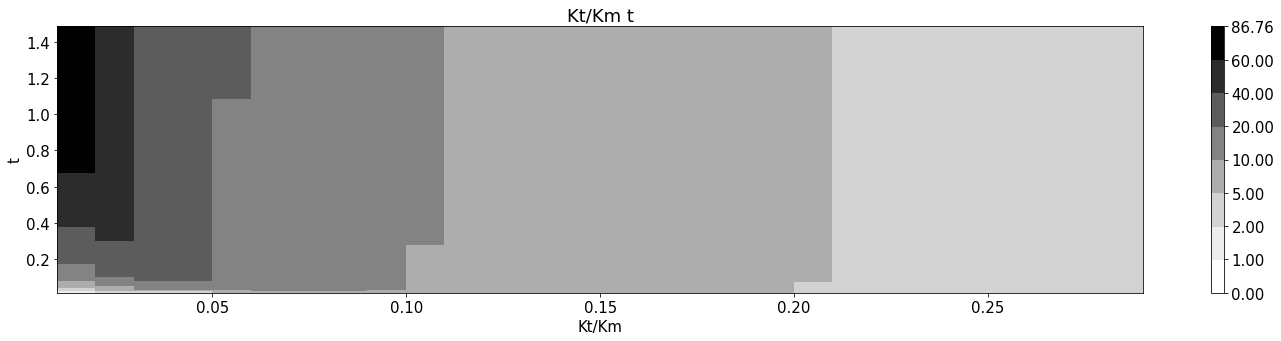

In [136]:
NoControlParam = 'Kt/(Kt*Km+R*J*p)'                    # коэффициент передачи без управления с параметрами Kt Km
NoControl = 'k/(k**2+R*J*p)'                           # коэффициент передачи без управления
PControl = 'k*Kp/(R*J*p + k**2 + Kp*k)'                # коэффициент передачи c пропорциональным звеном управления
IControl = 'k*Ki/(R*J*p**2+p*k**2+Ki*k)'               # коэффициент передачи c интегральным звеном управления
PIControl = '(p*Kp+Ki)*k/(p*(R*J*p+k**2)+(p*Kp+Ki)*k)' # коэффициент передачи с ПИ регулятором
constk = 0.03  # коэффициент пропорциональности
constR = 2.44  # сопротивление
constJ = 0.00003  # момент инерции 
parameters = dict(k = constk, R = constR, J = constJ, Ki = 0, Kp = 0, Kv = 0, Kt = 0, Km = 0)
SystemParametersHeatMap(NoControlParam, parameters, [0.01, 0.3, 0.01], [0.01, 1.5, 0.01])


Из физических соображений считаем $K_t$ = $K_m$. Значение коэффициента $K_m$ берём в соответствии с оценкой показателй реального мотора, из выражения, $$K_m =  \frac{V_m - R_m I_m}{\omega_m}$$, по результатам экспериментов $K_t = K_m = 0.03$. Как видно из хитмапа выше, при таком значении скорость ротора значительно возрастает за малый промежуток времени.


### Анализ АЧХ и переходной функции для системы без управления

$$K(p) =  \frac{k_t}{RJp+k_tk_m}$$

$$K(i\omega) =  \frac{k_t}{RJi\omega+k_tk_m}$$

$\text{АЧХ - амплитудно-частотная характеристика.}\\
\text{Эта величина характеризует характеризует амплитуду}\\
\text{установившихся вынужденных колебаний, при периодическом входном воздействии на частоте } \omega
$  

$$|K(i\omega)| = |\frac{k_t}{RJi\omega+k_tk_m}| = \frac{k_t}{(k_tk_m)^2+(RJ\omega)^2}$$

$\text{Пусть }$ $k_t$ = $k_m$ = $k$:

$$|K(i\omega)| = \frac{k}{\sqrt{k^4+(RJ\omega)^2}}$$
#### АЧХ

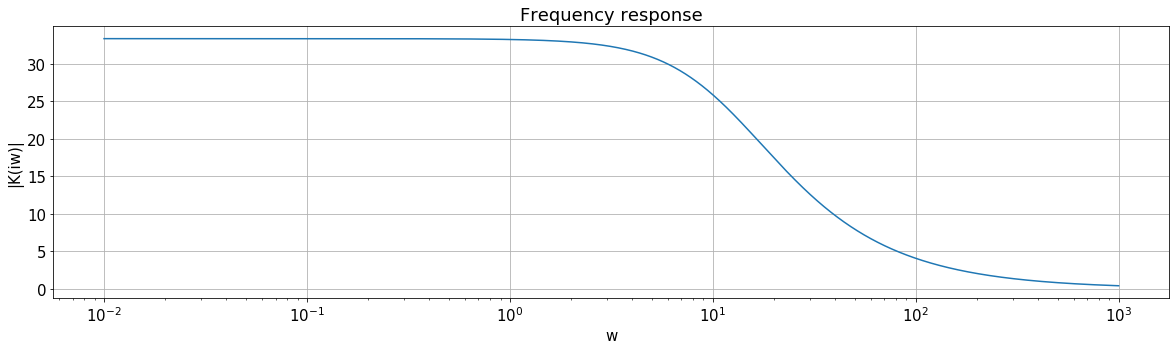

In [41]:
FreqResponse(NoControl,parameters,[0.01,1000,0.01])

#### Переходная функция

Входной сигнал:  1
Коэффициент передачи:
k/(k**2+R*J*p)
Время достижения максимума:  Нe существует(-1)
Перерегулирование:  Нe существует(-1)  %
Время установления:  Нe существует(-1)
Установившаяся статическая ошибка:  32.3333333333333


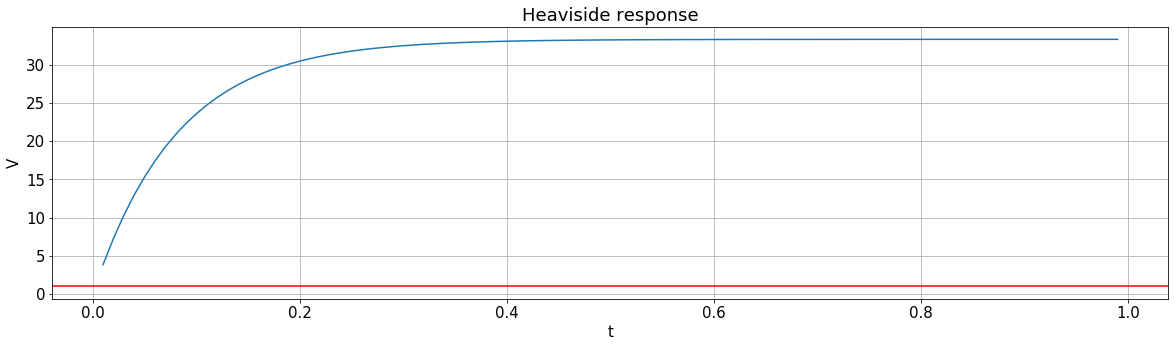

In [72]:
HeavisideResponse(NoControl,parameters,[0.01,1,0.01])

#### Анализ АЧХ и переходной функции
По приведённым выше графикам видно, что система без управления асимптотически устойчива, для её управления будет достаточно простого регулятора.

## Построение регулятора скорости вращения ##

### Пропорционально-интегрально-дифференцирующий регулятор
$
\text{Пропорциональная составляющая вырабатывает выходной сигнал,}\\
\text{противодействующий отклонению регулируемой величины от заданного значения}\\
\text{Однако, существует статическая ошибка, которая равна такому отклонению.}\\
\text{Чем больше коэффициент пропорциональности, тем меньше статическая ошибка.}\\
\text{Oднако при слишком большом коэффициенте усиления при наличии запаздывания в системе могут начаться автоколебания.}
~\\
\text{На помощь к нам приходит интегральная составляющая, которая устранения статическую ошибку,}\\
\text{но приводит к колебаниям в системе.}\\
~\\
\text{Дифференцирующая составляющая позволяет сделать систему более устойчевой, но она излишняя.}\\
$
![alt text](https://sun9-27.userapi.com/c853520/v853520157/17099b/DzR7EUKknpM.jpg)
$$
~\\
K_{pi} = \frac{(pK_{p}+K_{i})k}{RJp^2+k^2p+(pK_{p}+K_{i})k}
$$


$
\text{Требования на переходной процесс:}\\ 
\text{Время достижения максимума (время существенного роста) не превышает 0.15 секунд}\\ 
\text{Перерегулирование (превышение реальной скорости над заданной) по
значению составляет не более 5%}\\ 
\text{Время установления не превышает 0.25 секунд}\\ 
\text{Установившаяся статическая ошибка должна равна 0%}\\ 
~\\
$

### Способы определения характеристик переходного процесса
#### Установившаяся статическая ошибка
Статическая ошибка $ = |\lim_{t\to\infty}H(t) - 1 |$ , где $H(t)$ - переходная функция, оригинал $\frac{K(p)}{p}$
Если статическая ошибка не равна нулю, то остальные характеристики не находятся.
#### Время достижения первого максимума
В случае если переходная функция $H(t)$ при t>0 только возрастает, то ищем время существенного роста (достижения 90% сигнала), если же нет, то первый максимум можно найти как первую стационарную точку $H(t)$ , которая является решением уравнения $h(t) = 0$ , где $h(t)$ - импульсная переходная функция (производная $H(t)$), оригинал K(p). Решения производится численно, ищется ближайший к нулю положительный корень. 
#### Перерегулирование
В случае если переходная функция $H(t)$ при t>0 только возрастает, то перерегулирование равно нулю. Иначе перерегулирование $ = |H(t_p) - 1 | $
#### Время установления
В случае если переходная функция $H(t)$ при t>0 только возрастает, то перебором значений функции $H(t)$ до попадания в 1% окрестность сигнала. Иначе находим первую стационарную точку, значение в которой попадает в 1% окрестность и производим обратный перебор до выхода из 1% окрестности (используя свойство периодичности корней)

### Выбор оптимальных параметров с помощью тепловых карт

100.0 %


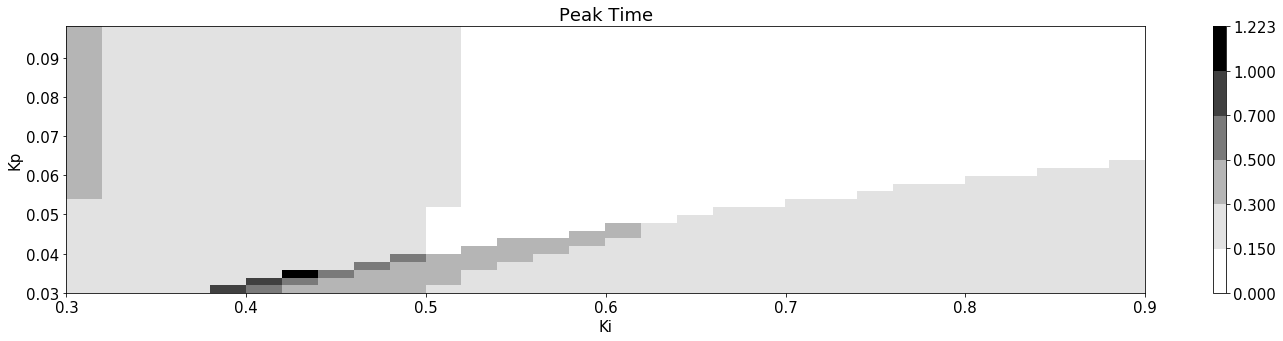

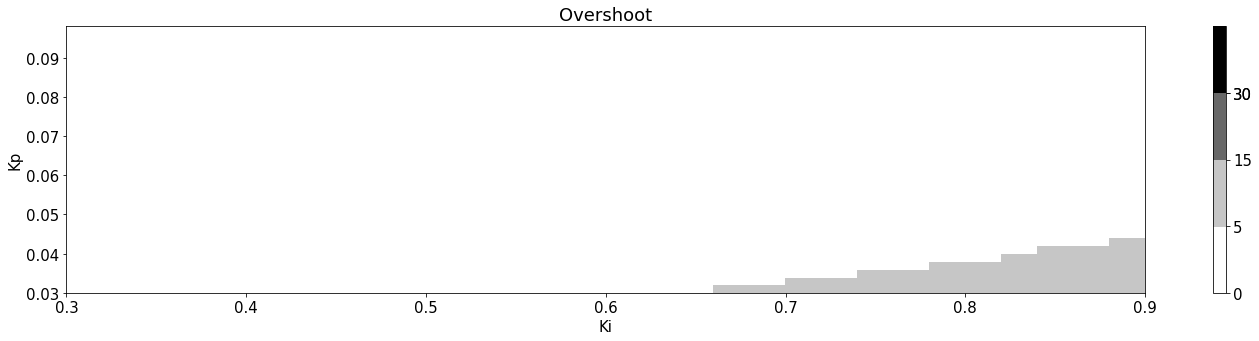

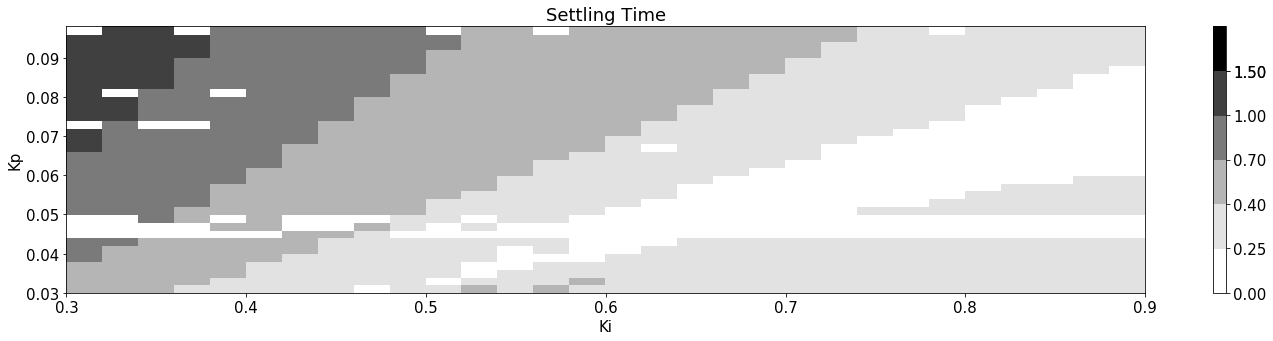

In [51]:
ResponseCharsHeatMaps(PIControl, parameters, 'Ki','Kp',[0.3,0.9,0.02], [0.03,0.1,0.002])

Проведём серию экспериментов для различных параметров для того чтобы подобрать оптимальные, руководствуясь  тепловыми картами для критериев. Дополнительно проверим управление состоящее только из пропорционального или интегрирующего звена (без построения тепловых карт)

Входной сигнал:  1
Коэффициент передачи:
k*Kp/(R*J*p + k**2 + Kp*k)
Время достижения максимума:  Нe существует(-1)
Перерегулирование:  Нe существует(-1)  %
Время установления:  Нe существует(-1)
Установившаяся статическая ошибка:  0.375000000000000


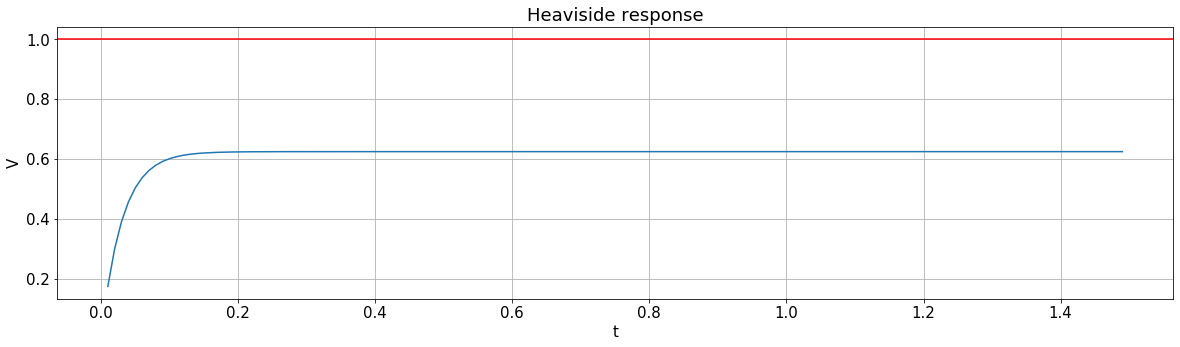

In [71]:
params = parameters 
params['Kp'] = 0.05
HeavisideResponse(PControl, params, [0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
k*Ki/(R*J*p**2+p*k**2+Ki*k)
Время достижения максимума:  0.305643
Перерегулирование:  15.275  %
Время установления:  0.761
Установившаяся статическая ошибка:  0


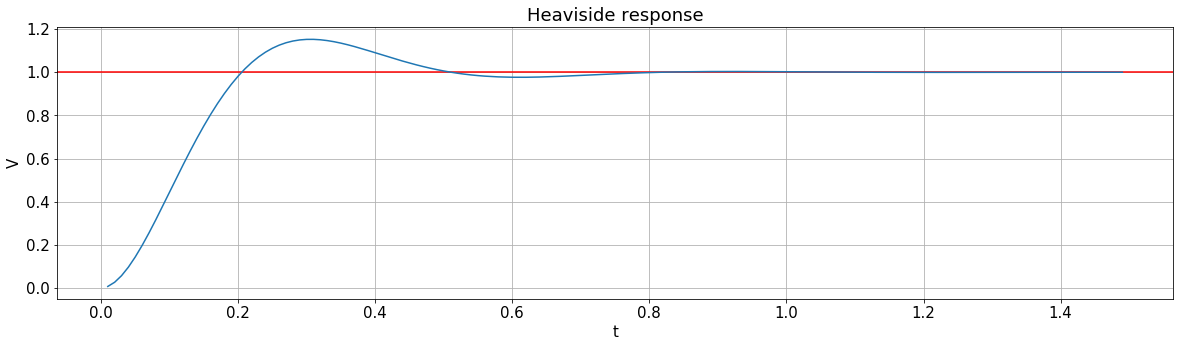

In [68]:
params = parameters 
params['Ki'] = 0.35
HeavisideResponse(IControl, params, [0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
k*Ki/(R*J*p**2+p*k**2+Ki*k)
Время достижения максимума:  0.184456
Перерегулирование:  32.176  %
Время установления:  0.791
Установившаяся статическая ошибка:  0


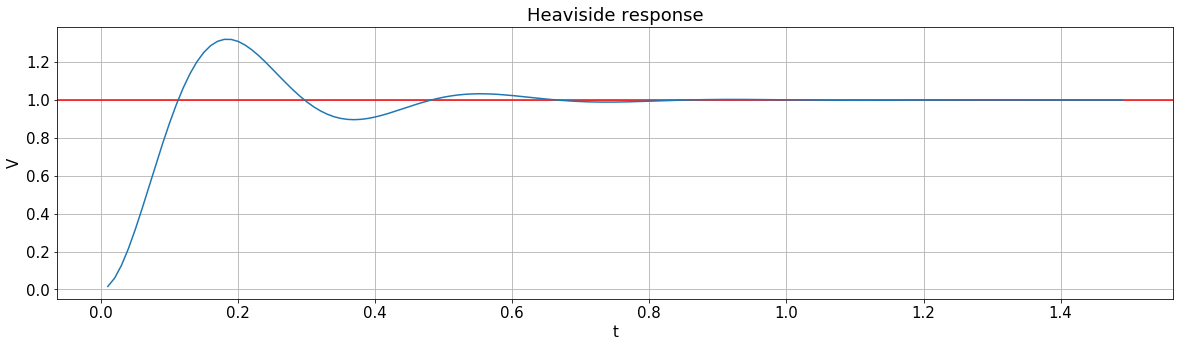

In [69]:
params = parameters 
params['Ki'] = 0.8
HeavisideResponse(IControl, params, [0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
(p*Kp+Ki)*k/(p*(R*J*p+k**2)+(p*Kp+Ki)*k)
Время достижения максимума:  0.23999999999999996
Перерегулирование:  0  %
Время установления:  0.8
Установившаяся статическая ошибка:  0


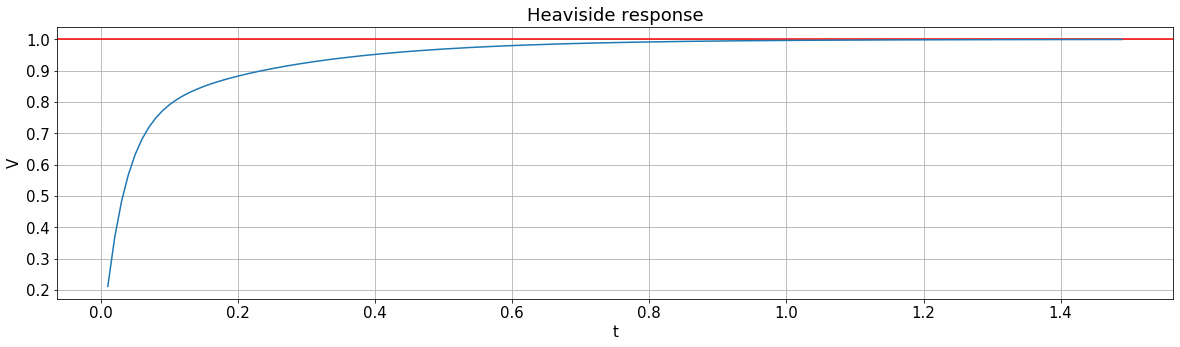

In [62]:
params = parameters 
params['Kp'] = 0.06
params['Ki'] = 0.35
HeavisideResponse(PIControl, params, [0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
(p*Kp+Ki)*k/(p*(R*J*p+k**2)+(p*Kp+Ki)*k)
Время достижения максимума:  0.265155
Перерегулирование:  2.117  %
Время установления:  0.388
Установившаяся статическая ошибка:  0


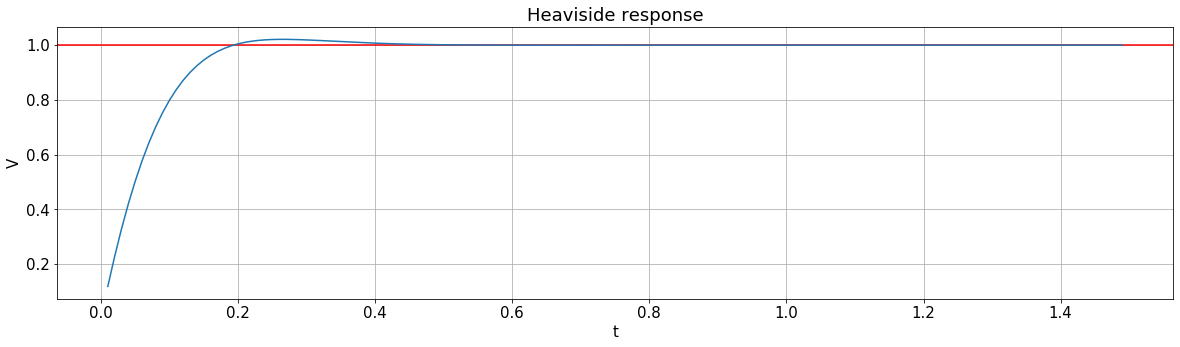

In [59]:
params = parameters 
params['Kp'] = 0.03
params['Ki'] = 0.53
HeavisideResponse(PIControl, params,[0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
(p*Kp+Ki)*k/(p*(R*J*p+k**2)+(p*Kp+Ki)*k)
Время достижения максимума:  0.12000000000000001
Перерегулирование:  0  %
Время установления:  0.2
Установившаяся статическая ошибка:  0


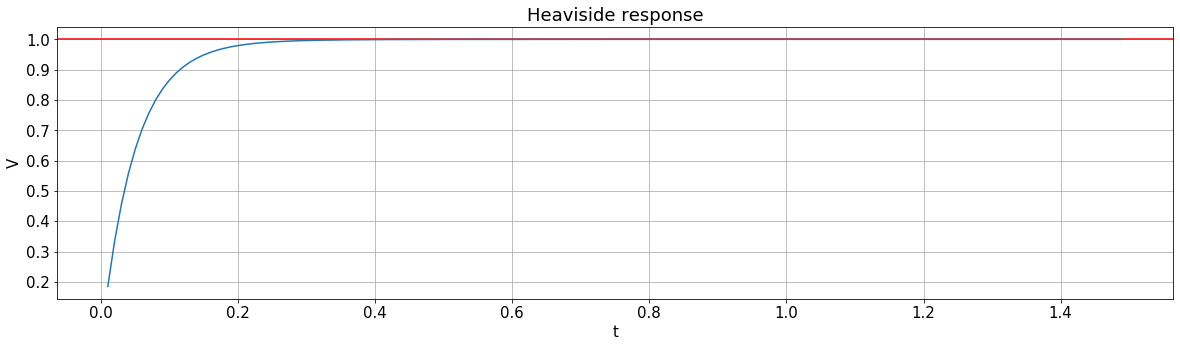

In [60]:
params = parameters 
params['Kp'] = 0.05
params['Ki'] = 0.6
HeavisideResponse(PIControl, params,[0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
(p*Kp+Ki)*k/(p*(R*J*p+k**2)+(p*Kp+Ki)*k)
Время достижения максимума:  0.1
Перерегулирование:  0  %
Время установления:  0.15
Установившаяся статическая ошибка:  0


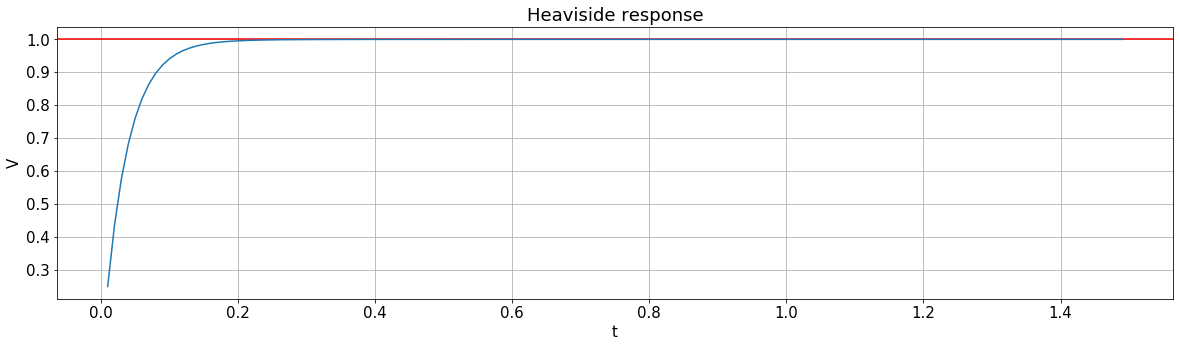

In [61]:
params = parameters 
params['Kp'] = 0.07
params['Ki'] = 0.85
HeavisideResponse(PIControl, params,[0.01,1.5,0.01])

### Результаты испытаний
| $K_p$                  | $K_i$                  | Время роста     | Перерегулирование  | Время установленя | Ошибка           |
| :------------------- | -------------------: |:---------------:| :---------------:  | :---------------: | :---------------:|
| 0.05 | 0 |- | - | - | 0.375 |
| 0 | 0.35 |0.306 | 15.28 | 0.761 | 0 |
| 0 | 0.8 |0.18 | 32.1 | 0.791 | 0 |
| 0.06| 0.35 |0.24 | 0 | 0.8 | 0 |
| 0.03| 0.53 |0.26 | 2.12 | 0.39 | 0 |
| 0.05| 0.6 |0.12 | 0 | 0.2 | 0 |
| 0.07| 0.85 |0.1 | 0 | 0.15 | 0 |

### Вывод
В таблице выше приведены результаты экспериментов по определению характеристик переходного процесса для различных регуляторов и параметров.
При использовании пропорционального регулятора появляется неустранимая статическая ошибка, он совершенно не подходит. Применение интегрального регулятора даёт корректный результат, однако не выполняются ограничения наложенные на переходной процесс. ПИ-регулятор позволяет найти такие значения параметров, что ограничения выполняются, такие параметры приведены в двух последних строках таблицы. В реальной системе выгоднее брать меньшие параметры, которые проще реализовать.

# Управление углом поворота вала DC-мотора ##
Во второй части лабораторной работы ставится более сложная задача - управление положением угла вала электромотора. Поскольку текущий угол поворота вала является интегралом от скорости вращения, а операции интегрирования соответствует коэффициент передачи, равный $\frac{1}{s}$, то DC-мотор, как объект управления в задаче отслеживания углового положения, оказывается уже звеном второго порядка, одним из полюсов – в нуле. Может возникнуть эффект появления статической ошибки слежения и потребоваться более сложно устроенное управление. Проверяться будет два управления: ПИ-регулятор, ПC-регулятор. Также будут введены ограничения на переходной процесс, а оптимальные для этого параметры будут подбираться двумя способами: исходя из тепловых карт (численный анализ) и модальное управление (аналитический анализ).

### Посторение системы дифференциальных уравнений

\begin{equation*}
 \begin{cases}
   U = RI + L\frac{dI}{dt} + kw, 
   \\
   J\frac{dw}{dt} = kI.
   \\
   \frac{d\theta}{dt} = w
 \end{cases}
\end{equation*}


### Переход к изображениям по Лапласу ###

\begin{equation*}
 \begin{cases}
\widetilde{U} = R\widetilde{I} + kp\widetilde{\theta},
\\
Jp^2\widetilde{\theta} = k\widetilde{I}.
 \end{cases}
\end{equation*}

$
\text{Cчитая, что}\\
\widetilde{U} - \text{вход системы}\\
\widetilde{\theta} - \text{выход системы}\\\
$
$$
K = \frac{\widetilde{\theta}}{\widetilde{U}} = \frac{k}{RJp^2+k^2p}\\
$$

In [ ]:
tfPosition = 'k/(k**2*p+R*J*p*p)'                                # Без управления
tfPositionPI = '(p*Kp*k+Ki*k)/(R*J*p*p*p+k**2*p*p+p*Kp*k+Ki*k)'  # ПИ-регулятор
tfPositionPD = 'Kp*k/(R*J*p*p+k*k*p+p*k*Kv+Kp*k)'                # ПC-регулятор

### Анализ АЧХ и переходной функции для системы без управления
#### АЧХ

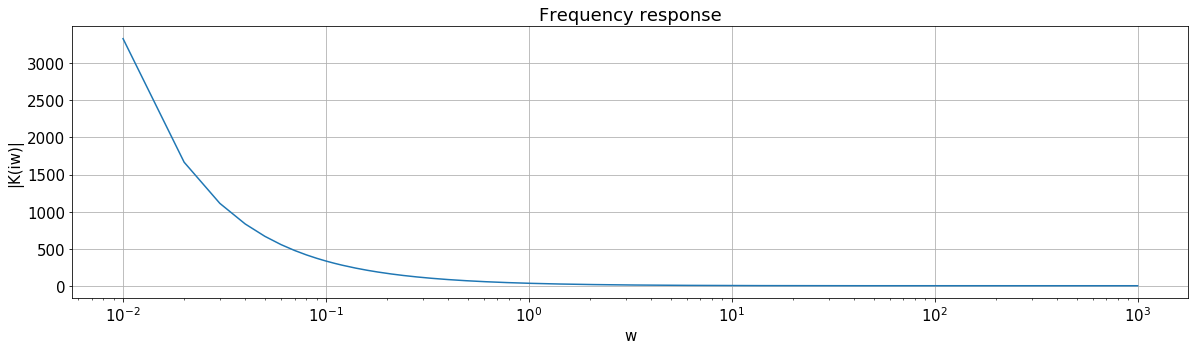

In [73]:
FreqResponse(tfPosition,parameters,[0.01,1000,0.01])

#### Переходная функция

Входной сигнал:  1
Коэффициент передачи:
k/(k**2*p+R*J*p*p)
Время достижения максимума:  Нe существует(-1)
Перерегулирование:  Нe существует(-1)  %
Время установления:  Нe существует(-1)
Установившаяся статическая ошибка:  oo


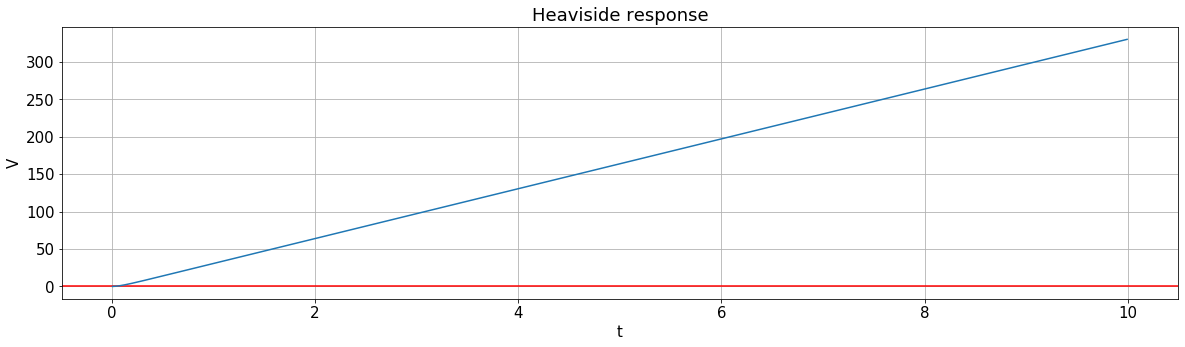

In [75]:
HeavisideResponse(tfPosition,parameters,[0.01,10,0.01])

#### Анализ АЧХ и переходной функции
Данная система не является асимптотически устойчивой без управления, могут возникать ошибки слежения, потребуется более сложное управление с двумя обратными связями

## Построение регулятора угла поворота 
Требования на переходный процесс сохраняются теми же. Для ПИ-регулятора оптимальные параметры ищем по тепловым картам, для
ПC-регулятора по тепловым картам, затем с помощью модального управления.
### Пропорционально-интегральный регулятор

![alt text](https://sun9-2.userapi.com/c853520/v853520157/1709ab/aTfMYmsQT8E.jpg)
$$
~\\
K_{pi} = \frac{(pK_{p}+K_{i})k}{p(RJp^2+k^2p)+(pK_{p}+K_{i})k}
$$

Входной сигнал:  1
Коэффициент передачи:
(p*Kp*k+Ki*k)/(R*J*p*p*p+k**2*p*p+p*Kp*k+Ki*k)
Время достижения максимума:  0.070137
Перерегулирование:  68.203  %
Время установления:  0.591
Установившаяся статическая ошибка:  0


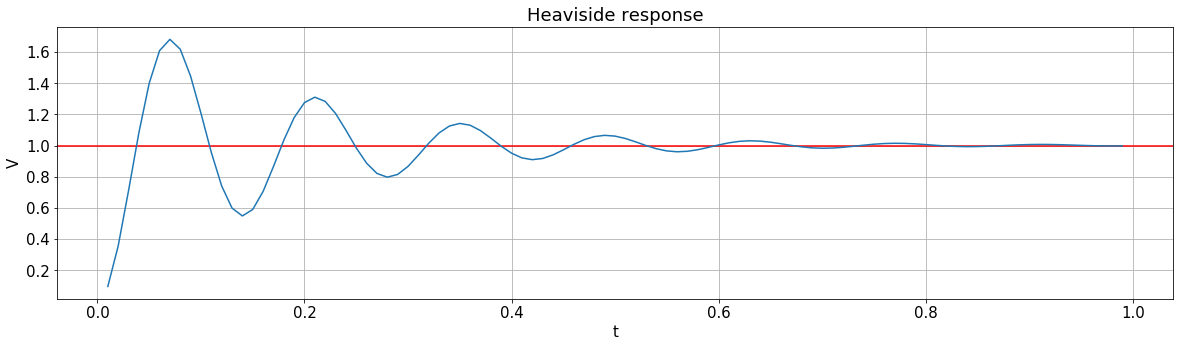

In [141]:
params = parameters
params['Ki'] = 5
params['Kp'] = 5
HeavisideResponse(tfPositionPI, params, [0.01,1,0.01], 1)

#### Выбор оптимальных параметров с помощью тепловых карт

100.0 %
[]


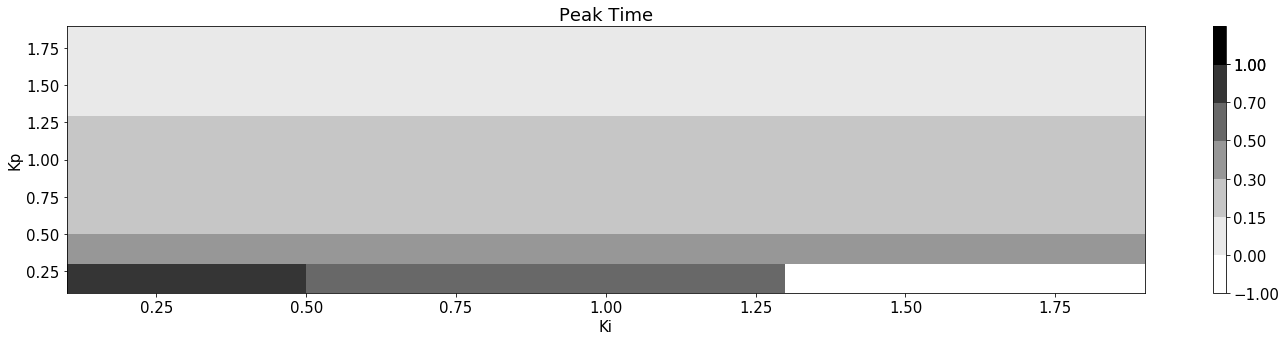

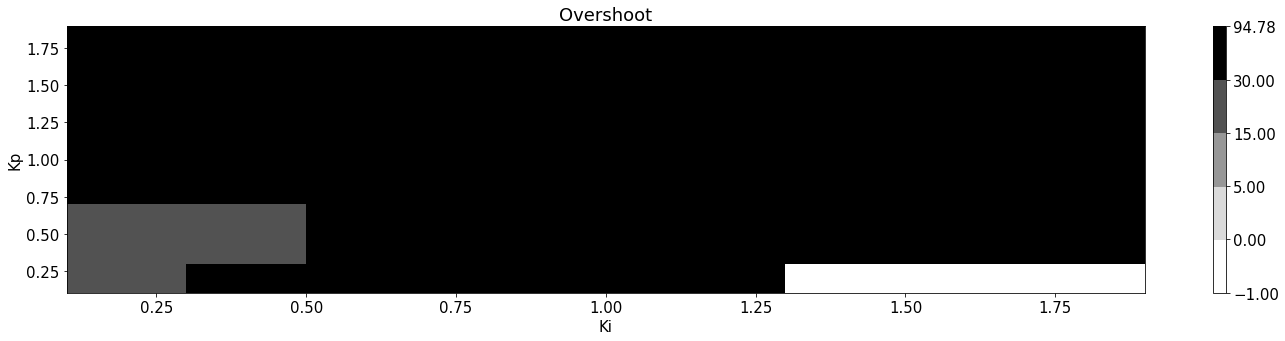

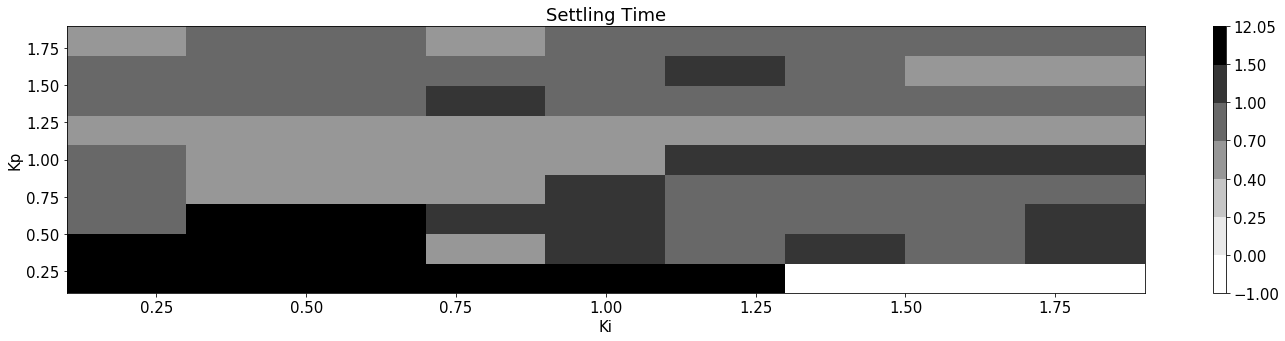

In [158]:
params = parameters
ResponseCharsHeatMapsWolf(tfPositionPI, params, 'Ki','Kp',[0.1, 2.1 ,0.2], [0.1, 2.1, 0.2])

По результатам построения тепловых карт, можно сделать вывод, что областей параметров подходящих под поставленные ограничения не нашлось, видимо управление имеет слишком простой вид для быстрого затухания колебаний, скорее всего необходимо добавить дифференциальную составляющую. Переходные функции для некоторых параметров представлены ниже.

Входной сигнал:  1
Коэффициент передачи:
(p*Kp*k+Ki*k)/(R*J*p*p*p+k**2*p*p+p*Kp*k+Ki*k)
Время достижения максимума:  0.16368
Перерегулирование:  41.755  %
Время установления:  0.967
Установившаяся статическая ошибка:  0


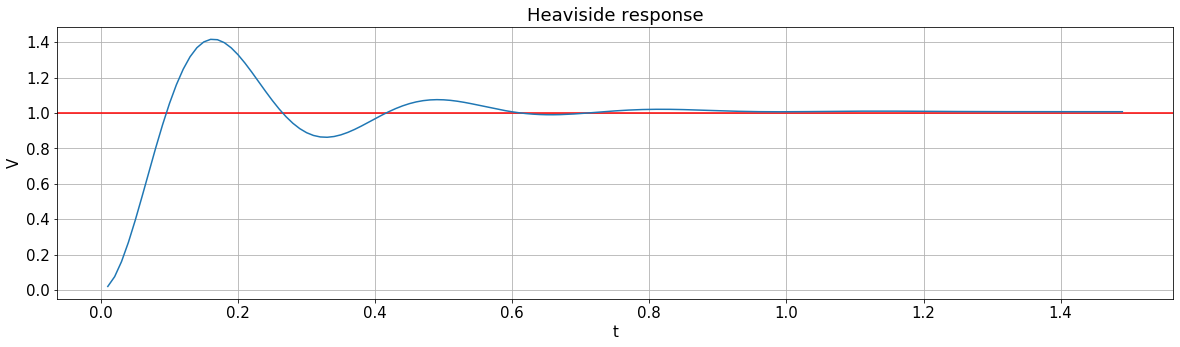

In [160]:
params = parameters
params['Ki'] = 0.75
params['Kp'] = 1
HeavisideResponse(tfPositionPI, params, [0.01, 1.5, 0.01], 1)

Входной сигнал:  1
Коэффициент передачи:
(p*Kp*k+Ki*k)/(R*J*p*p*p+k**2*p*p+p*Kp*k+Ki*k)
Время достижения максимума:  0.244826
Перерегулирование:  27.107  %
Время установления:  2.248
Установившаяся статическая ошибка:  0


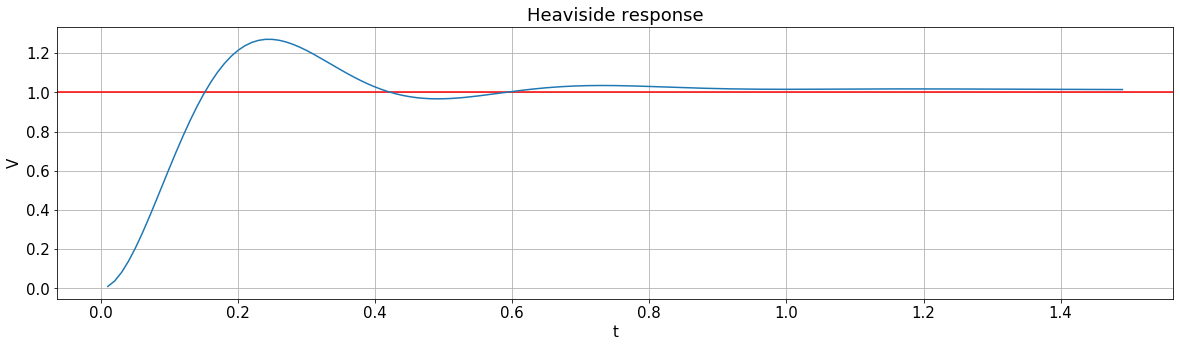

In [161]:
params = parameters
params['Ki'] = 0.25
params['Kp'] = 0.5
HeavisideResponse(tfPositionPI, params, [0.01, 1.5, 0.01], 1)

### Пропорционально-скоростной регулятор

![alt text](https://sun9-66.userapi.com/c853520/v853520109/16c4db/VwJeOVQjWMY.jpg)


$$
~\\
K_{pv} = \frac{K_{p}k}{RJp^2+pk^2+pkK_v+K_pk}
$$
#### Выбор оптимальных параметров с помощью тепловых карт

100.0 %


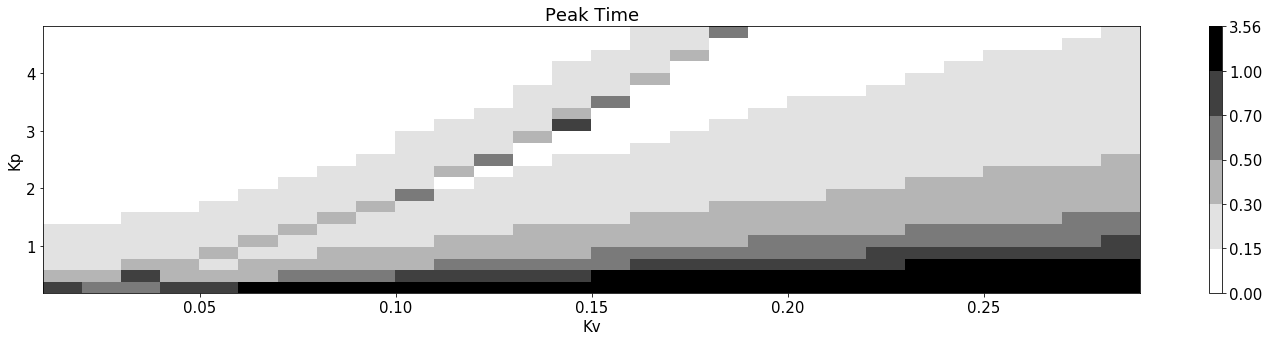

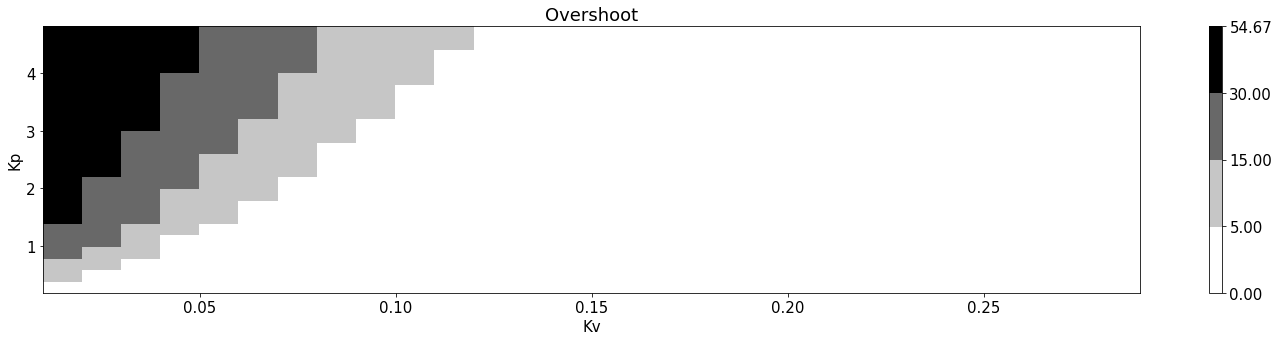

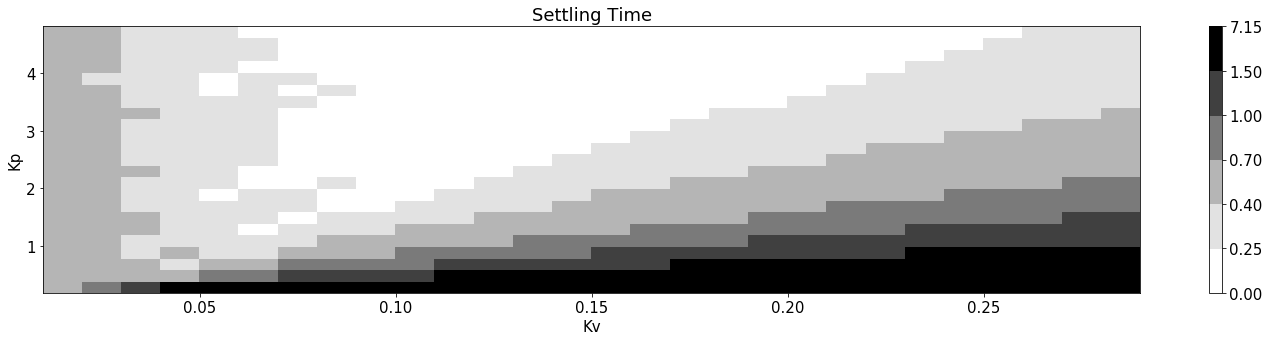

In [98]:
ResponseCharsHeatMaps(tfPositionPD, params, 'Kv','Kp',[0.01,0.3,0.01], [0.2,5,0.2])

Проведём серию экспериментов для различных параметров для того чтобы подобрать оптимальные, руководствуясь  тепловыми картами для критериев.

Входной сигнал:  1
Коэффициент передачи:
Kp*k/(R*J*p*p+k*k*p+p*k*Kv+Kp*k)
Время достижения максимума:  0.168891
Перерегулирование:  6.274  %
Время установления:  0.307
Установившаяся статическая ошибка:  0


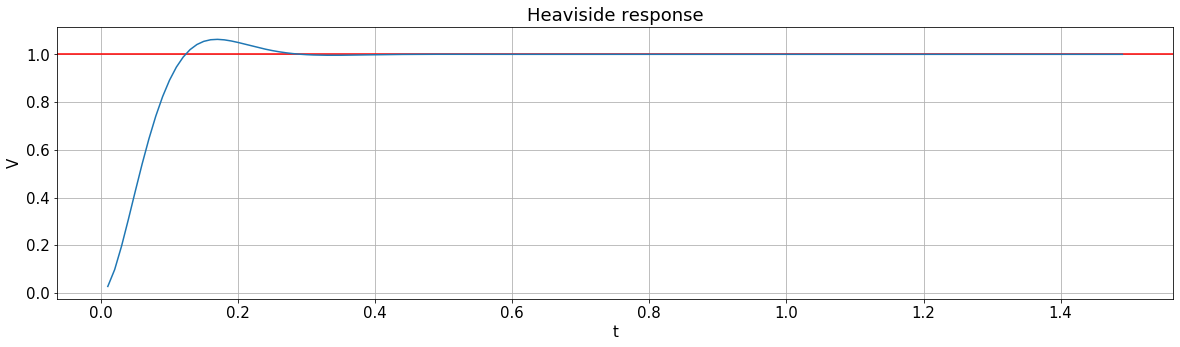

In [86]:
params = parameters 
params['Kp'] = 1.5
params['Kv'] = 0.05
HeavisideResponse(tfPositionPD, params, [0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
Kp*k/(R*J*p*p+k*k*p+p*k*Kv+Kp*k)
Время достижения максимума:  0.32
Перерегулирование:  0  %
Время установления:  0.65
Установившаяся статическая ошибка:  0


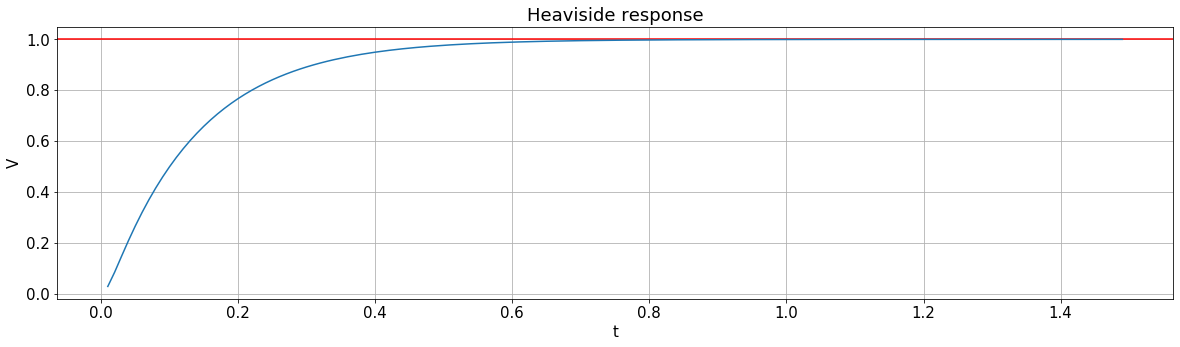

In [87]:
params = parameters 
params['Kp'] = 2
params['Kv'] = 0.25
HeavisideResponse(tfPositionPD, params, [0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
Kp*k/(R*J*p*p+k*k*p+p*k*Kv+Kp*k)
Время достижения максимума:  0.365438
Перерегулирование:  0.0  %
Время установления:  0.181
Установившаяся статическая ошибка:  0


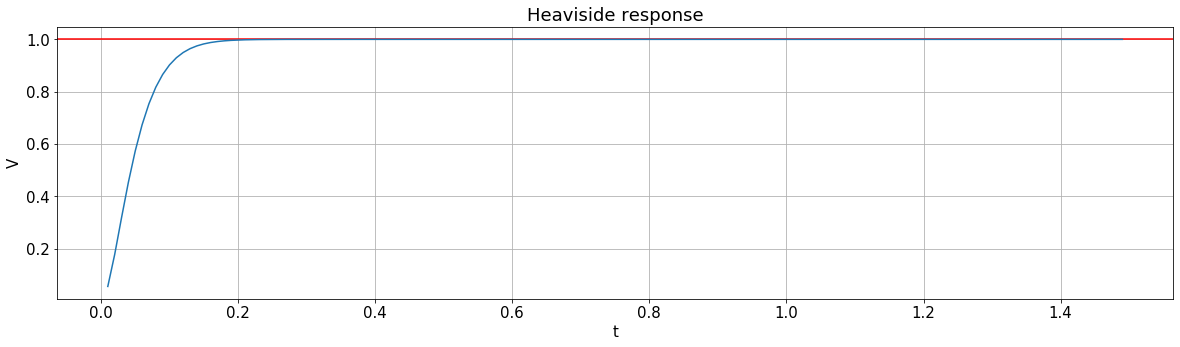

In [88]:
params = parameters 
params['Kp'] = 3.5
params['Kv'] = 0.15
HeavisideResponse(tfPositionPD, params, [0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
Kp*k/(R*J*p*p+k*k*p+p*k*Kv+Kp*k)
Время достижения максимума:  0.14
Перерегулирование:  0  %
Время установления:  0.2
Установившаяся статическая ошибка:  0


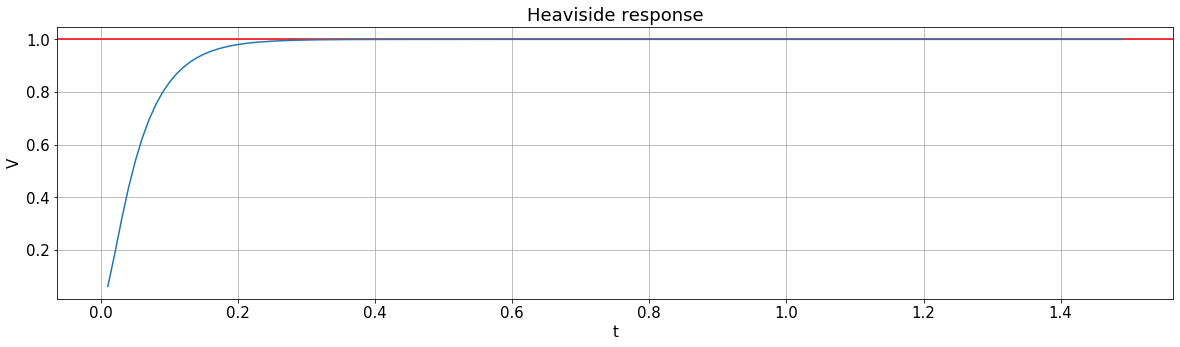

In [89]:
params = parameters 
params['Kp'] = 4.2
params['Kv'] = 0.22
HeavisideResponse(tfPositionPD, params, [0.01,1.5,0.01])

Входной сигнал:  1
Коэффициент передачи:
Kp*k/(R*J*p*p+k*k*p+p*k*Kv+Kp*k)
Время достижения максимума:  0.137787
Перерегулирование:  2.546  %
Время установления:  0.189
Установившаяся статическая ошибка:  0


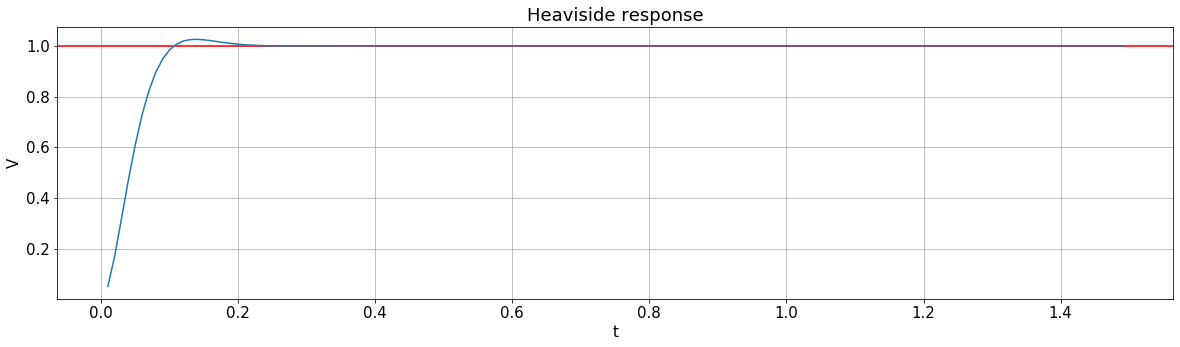

In [91]:
params = parameters 
params['Kp'] = 3
params['Kv'] = 0.1
HeavisideResponse(tfPositionPD, params, [0.01,1.5,0.01])

| $K_p$                  | $K_v$                  | Время роста     | Перерегулирование  | Время установленя | Ошибка           |
| :------------------- | -------------------: |:---------------:| :---------------:  | :---------------: | :---------------:|
| 1.5 | 0.05 |0.17 | 6.27 | 0.3 | 0 |
| 2 | 0.25 |0.32 | 0 | 0.65 | 0 |
| 3.5 | 0.15 |0.36 | 0 | 0.181 | 0 |
| 4.2| 0.22 |0.14 | 0 | 0.2 | 0 |
| 3| 0.1 |0.14 | 2.54 | 0.189 | 0 |


Итак, снова в последних двух строках параметры обеспечивают переходной процесс, который соответствует всем наложенным требованиям.

####  Корневые методы обеспечения заданного качества протекания переходного процесса (модальное управление)

$
\text{Отклик линейного
динамического звена со знаменателем в виде характеристического полинома
степени 2 будет иметь вид:}\\ 
$
$$
A_1e^{p_1t}+A_2e^{p_2t}
$$

$
\text{Хотим чтобы все составляющие переходного процесса затухали не медленнее, чем } e^{-c_1t}\\
\text{Все колебательные составляющие, переходного процесса за время их периода затухали не менее, чем в } e^{\frac{-2\pi}{c_2}}\\
\text{Для обеспечения заданного качества протекания переходного процесса решим характеристическое уравнение:}
$

$$
RJp^2+p(k^2+kK_v)+K_pk = 0 \\
p^2+ap+b = 0
$$
$
\text{Его корни: }
$

$$
p_{1,2} = \frac{-(k^2 + K_vk)k±\sqrt{(K_vk+k^2)^2-4RJkKp}}{2RJ}
$$
$
\text{Тогда должны выполняться соотношения: }
$
$$
e^{p_{1,2}t} \leqslant e^{-c_1t}
$$

$$
Im(p_{1,2}) = w_{1,2} 
$$
$$
e^{(Re(p_{1,2})±iw_{1,2})\frac{2\pi}{w_{1,2}}} \leqslant e^{\frac{-2\pi}{c2}t} 
$$

$
\text{Упростим и получим: }
$
$$
\begin{equation*}
 \begin{cases}
   Re(p_{1,2}) \leqslant -c1, 
   \\
   |Im(p_{1,2})| \leqslant c2|Re(p_{1,2})|
 \end{cases}
\end{equation*}
$$

![alt text](https://sun9-71.userapi.com/c856120/v856120408/175f65/HyV0pgDwlBo.jpg)

$$
D: p(w) = \\
\begin{equation*}
 \begin{cases}
   \frac{w}{c_2}+iw,     w < -c_1c_2, 
   \\
   -c_1 + iw,    -c_1c_2 \leqslant w \leqslant c_1c_2,
   \\
   -\frac{w}{c_2}+iw,    w > c_1c_2, 
 \end{cases}
\end{equation*}
$$

$
p = -c_1 + iw \\
c_1^2-w^2-2ic_1w+a(-c_1+iw)+b = 0 \\
Re: -с_1a + b = w^2-c_1^2 \\
Im: wa = 2c_1w \\
\delta(w) = -w \\
\delta(w)_a = -2c_1w \\
\delta(w)_b = (w^2+c_1^2)w \\
\text{Особая прямая при: } w = 0 \\
b = ac_1-c_1^2\\
\text{Неособые решения при: } \\
a = 2c_1 \\
b = w^2+c_1^2 \\
-c_1c_2 \leqslant w \leqslant c_1c_2
$

$
\text{Аналогично находим другое решение при: } w\notin[-c_1c_2, c_1c_2] \\
b = \frac{a^2(c_2+1)}{4}
$

$
\text{Методом D-разбиения получаем необходимую для параметров область}\\
$
![alt text](https://sun9-34.userapi.com/c856120/v856120660/17fc57/jjBdGWYpG4g.jpg)

$
2c_1 \leqslant a \\
ac_1-c_1^2 \leqslant b \leqslant \frac{a^2(c_2+1)}{4} \\
a = \frac{k^2+kK_v}{RJ} \\
b = \frac{k^2}{RJ} \\
\text{Аналитически полученная область для $c_1 = c_2 = 1$}
$
![alt text](https://sun9-52.userapi.com/c858320/v858320590/1122f9/EUXJlfcLd4g.jpg)
$\text{Численно получим набор значений $K_p$ и $K_v$, удовлетворяющих поставленным требованиям на затухание процессов для тех же значений:}$

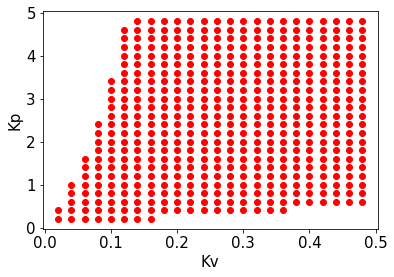

In [129]:
ModalControl(tfPositionPD, params,1,1)

Также можно сказать что среди этих значений есть и те что удовлетворяют ранее наложенным требованиям на переходной процесс, найти их можно соотнеся тепловые карты с данным графиком. Например:

Входной сигнал:  1
Коэффициент передачи:
Kp*k/(R*J*p*p+k*k*p+p*k*Kv+Kp*k)
Время достижения максимума:  0.12000000000000001
Перерегулирование:  0  %
Время установления:  0.2
Установившаяся статическая ошибка:  0


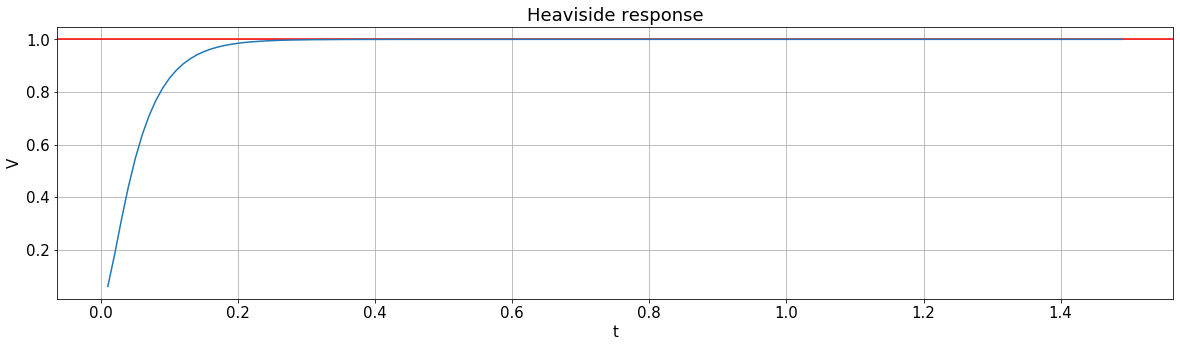

In [130]:
params = parameters 
params['Kp'] = 4
params['Kv'] = 0.2
HeavisideResponse(tfPositionPD, params, [0.01,1.5,0.01])

## Вывод
ПИ-регулятор не подходит для построения управления по положению, параметров, подходящих под поставленные ограничения не существует. Однако есть предположение, что добавление дифференциальной составляющей может исправить положение. Пропорционально-скоростной регулятор, как видно по тепловым картам имеет достаточно обширную область для выбора оптимальных параметров, из которых мы стараемся выбрать наименьшие (удобство реальной реализации). Также был рассмотрен альтернативный способ подбора параметров под другие требования (ограничения на скорость затухания). В таком случае тоже удалось найти области подходящих параметров, в которых кроме того есть и те что удовлетворяют поставленным ранее требованиям. Отсюда вывод, что для управления положением угла DC-мотора ПС-регулятор предпочтительнее. 